# <font color="red"> CellProfiler: profiling of DCP1A P-Bodies in Coyne's data </font>

JIRA task: NN-87

Why Linear Mixed-Effects Models (LMMs)?
Your experimental structure involves:

- Measurements per site image (the dependent variable)

- Patients as subjects, with 10 repeated measures (site images) per patient

- Gene group as the fixed effect of interest (WT, C9, +sALS, -sALS)

- Random variation across patients, potentially nested in gene groups

This design includes both fixed effects (gene group) and random effects (patient) — perfect for LMMs.



NOTE:

If mixed model fails (e.g., singular random effects, low variance), we fall back to a fixed-effects model 
where we fit:
ols("feature_value ~ C(gene_group) + C(patient_id)", data=...)
In this model, we estimates how gene groups differ from a reference group (C(gene_group)) after **adjusting** for per-patient shifts (C(patient_id), batch correction)
Residual error:	Site-to-site variation within a patient. You're estimating how gene groups affect the measurement, controlling for (not modeling) patient variability. Each patient gets its own intercept, but you don't estimate a variance across patients (like in mixed models)


In [6]:
from pathlib import Path
import glob
import sys
import os


os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/'
os.environ['NOVA_DATA_HOME'] = f"{os.environ['NOVA_HOME']}/input"
print('NOVA_HOME is at', os.getenv('NOVA_HOME'))
sys.path.insert(1, os.getenv('NOVA_HOME'))


import numpy as np
import pandas as pd
import seaborn as sns
from markdown import markdown
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.formula.api as smf


from cell_profiler.code.cp_effect_size_utils import CP_OUTPUTS_FOLDER, validate_cp_files, extract_path_parts, merge_on_group, collect_cp_results_by_cell_line, load_cp_results, get_features_per_image, get_aggregated_features_per_image, collect_all_features, assign_gene_group_Coyne_new, assign_plate_Coyne_new, assign_gene_group_Coyne_old, run_analysis_generate_report, print_mixedlm_conclusions, measures_to_plot
from manuscript.plot_config import PlotConfig

%load_ext autoreload    
%autoreload 2

NOVA_HOME is at /home/projects/hornsteinlab/Collaboration/NOVA/


# Old Coyne dataset

In [2]:
ANALYSIS_TYPE = 'PB_profiling/coyne_old_DCP1A'   
BATCHES = ['batch1']

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/AlyssaCoyne/cell_profiler/PB_profiling/coyne_old_DCP1A'

# Font
FONT_PATH = '/home/projects/hornsteinlab/sagyk/anaconda3/envs/nova/fonts/arial.ttf'
from matplotlib import font_manager as fm
import matplotlib
fm.fontManager.addfont(FONT_PATH)
matplotlib.rcParams['font.family'] = 'Arial'

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 6
})

In [7]:
group_by_columns = ['ImageNumber', 'batch', 'rep', 'cell_line']
REQUIRED_FILES = ['Image.csv', 'Pbodies.csv', 'Cytoplasm.csv']

In [4]:
# Test CP outputs (number of images)
if False:
    pattern = os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, '*', '*', '*', '*', '*', '*')
    # store marker folders by cell line
    for marker_path in glob.glob(pattern):
        if os.path.isdir(marker_path):
            try:
                image_df = pd.read_csv(marker_path +'/Image.csv')
                print(marker_path, image_df.shape)
                #print(image_df[['Count_Pbodies', 'Count_nucleus']].head(10))

                #parts_df = image_df['URL_DAPI'].apply(extract_path_parts)
                #print(marker_path, parts_df['rep'].unique(), parts_df['cell_line'].unique())

                marker = os.path.basename(marker_path)    
                cell_line = Path(marker_path).resolve().parents[3].name
            except FileNotFoundError as e:
                print("!!!!")
                print(e)
        else:
            print(f"Not a marker folder directory:{marker_path}")


## Collect CP files by "cell_line" (paths_by_cell_line[cell_line]) and Load CP data

In [5]:
# Collect paths of CP output files
paths_by_cell_line = collect_cp_results_by_cell_line(ANALYSIS_TYPE)

In [6]:
# Load CP data
cp_data = load_cp_results(paths_by_cell_line, REQUIRED_FILES)


number of subjects from cell line c9orf72ALSPatients: 3
number of subjects from cell line sALSNegativeCytoTDP43: 2
number of subjects from cell line Controls: 6
number of subjects from cell line sALSPositiveCytoTDP43: 10


In [7]:
# Get the calculated features from all CP output files
cp_measurements = collect_all_features(cp_data, group_by_columns)

c9orf72ALSPatients (30, 5) (30, 31) (30, 17)
(30, 32)
(30, 45)
sALSNegativeCytoTDP43 (20, 5) (20, 31) (20, 17)
(20, 32)
(20, 45)
Controls (60, 5) (60, 31) (60, 17)
(60, 32)
(60, 45)
sALSPositiveCytoTDP43 (100, 5) (100, 31) (100, 17)
(100, 32)
(100, 45)
Shape after merging is: (210, 45)


In [8]:
# Add gene_group
cp_measurements['gene_group'] = cp_measurements['cell_line']#.apply(assign_gene_group_Coyne_old)
print(cp_measurements['gene_group'].unique())

# Fiilter by lines
lines_to_include = ["Controls", "c9orf72ALSPatients", "sALSNegativeCytoTDP43", "sALSPositiveCytoTDP43"]
cp_measurements = cp_measurements[cp_measurements['gene_group'].isin(lines_to_include)]
print(cp_measurements.shape)


# Add patient_id
cp_measurements['patient_id'] = cp_measurements['gene_group']+"_"+cp_measurements['rep']
print(cp_measurements['patient_id'].unique())

# Important to put the reference group first in order for mixedlm() - has to be Categorical!
cp_measurements["gene_group"] = pd.Categorical(
    cp_measurements["gene_group"],
    categories=lines_to_include,
    ordered=True
 )



['c9orf72ALSPatients' 'sALSNegativeCytoTDP43' 'Controls'
 'sALSPositiveCytoTDP43']
(210, 46)
['c9orf72ALSPatients_rep1' 'c9orf72ALSPatients_rep2'
 'c9orf72ALSPatients_rep3' 'sALSNegativeCytoTDP43_rep1'
 'sALSNegativeCytoTDP43_rep2' 'Controls_rep1' 'Controls_rep2'
 'Controls_rep3' 'Controls_rep4' 'Controls_rep5' 'Controls_rep6'
 'sALSPositiveCytoTDP43_rep1' 'sALSPositiveCytoTDP43_rep10'
 'sALSPositiveCytoTDP43_rep2' 'sALSPositiveCytoTDP43_rep3'
 'sALSPositiveCytoTDP43_rep4' 'sALSPositiveCytoTDP43_rep5'
 'sALSPositiveCytoTDP43_rep6' 'sALSPositiveCytoTDP43_rep7'
 'sALSPositiveCytoTDP43_rep8' 'sALSPositiveCytoTDP43_rep9']


In [9]:
#cp_measurements[['rep', 'cell_line']].value_counts()
cp_measurements[['patient_id', 'gene_group']].value_counts()


patient_id                   gene_group           
Controls_rep1                Controls                 10
Controls_rep2                Controls                 10
Controls_rep3                Controls                 10
Controls_rep4                Controls                 10
Controls_rep5                Controls                 10
Controls_rep6                Controls                 10
c9orf72ALSPatients_rep1      c9orf72ALSPatients       10
c9orf72ALSPatients_rep2      c9orf72ALSPatients       10
c9orf72ALSPatients_rep3      c9orf72ALSPatients       10
sALSNegativeCytoTDP43_rep1   sALSNegativeCytoTDP43    10
sALSNegativeCytoTDP43_rep2   sALSNegativeCytoTDP43    10
sALSPositiveCytoTDP43_rep1   sALSPositiveCytoTDP43    10
sALSPositiveCytoTDP43_rep10  sALSPositiveCytoTDP43    10
sALSPositiveCytoTDP43_rep2   sALSPositiveCytoTDP43    10
sALSPositiveCytoTDP43_rep3   sALSPositiveCytoTDP43    10
sALSPositiveCytoTDP43_rep4   sALSPositiveCytoTDP43    10
sALSPositiveCytoTDP43_rep5   sALSPosi

In [10]:
#cp_measurements[['patient_id']].value_counts()

In [11]:
#cp_measurements[['gene_group']].value_counts()

In [12]:

def plot_cp_feature_grouped_by_gene(cp_measurements, cp_feature_col, group_col="gene_group", patient_col="patient_id", color_mapping=None, model_results_df=None, pdf_file=None):
    
    df = cp_measurements.copy()

    # Define fixed color and label mapping for both group_col and patient_col
    groups = df[group_col].astype(str).unique().tolist() + df[patient_col].astype(str).unique().tolist()
    _palette = {}
    for g in groups:
        if g in color_mapping: _palette[color_mapping[g]['alias']] = color_mapping[g]['color']
    if patient_col=='batch':
        for b in df[patient_col].astype(str).unique().tolist():
            _palette[b]='gray'

    # Rename groups to aliases
    label_mapping = {k: v["alias"] for k, v in color_mapping.items() if k in groups}
    df[group_col] = df[group_col].cat.rename_categories(label_mapping)
    df[patient_col] = df[patient_col].astype("category").cat.rename_categories(label_mapping)
    
    # Determine group order and x-axis positions for each group 
    groups_order = sorted(df[group_col].unique(), reverse=False)
    x_spacing = 0.4
    x_pos_map = {label: i * x_spacing for i, label in enumerate(groups_order)}
    
    # Setup plot
    sns.set(style="white", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(3, 4))
    line_width = 1
    
    # ============================
    # Plot each group manually by numeric x
    # ============================
    for i, group in enumerate(groups_order):
        
        group_data = df[df[group_col] == group]
        xpos = x_pos_map[group]
        
        # Boxplot for group
        sns.boxplot(
            data=group_data,
            y=cp_feature_col,
            hue=group_col, #patient_col,
            ax=ax,
            width=0.3,
            linewidth=line_width,
            showfliers=False,
            showmeans=True,
            meanline=True,
            meanprops={"linestyle": "-", "color": "black", "linewidth": line_width},
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=line_width),
            whiskerprops=dict(linewidth=line_width-0.3, color='black'),
            capprops=dict(linewidth=line_width, color='black'),
            medianprops=dict(visible=False),
            positions=[x_pos_map[group]]
        )
        
        # ============================
        # Full distribution: raw cell-level/image-level points (light gray)
        # ============================ 
        patient_ids = group_data[patient_col].unique()
        for i, patient in enumerate(patient_ids):
            patient_data = group_data[group_data[patient_col] == patient]

            ax.scatter(
                x=np.random.normal(loc=x_pos_map[group], scale=0.05, size=len(patient_data)),  # jitter
                y=patient_data[cp_feature_col],
                color=_palette.get(patient, 'black'),#'lightgray',
                s=2.5,
                alpha=0.3,
                zorder=1
            )

    # ============================
    # Overlay per-patient means (means as colored points)
    # ============================
    patient_means = df.groupby([group_col, patient_col], observed=True)[cp_feature_col].mean().reset_index()

    for _, row in patient_means.iterrows():
        group = row[group_col]
        patient = row[patient_col]

        # Skip if value is missing
        if pd.isna(group) or pd.isna(patient) or pd.isna(row[cp_feature_col]):
            continue
        
        xpos = x_pos_map.get(group)
        y = row[cp_feature_col]

        if pd.isna(xpos) or pd.isna(y):
            continue

        jittered_x = np.random.normal(loc=xpos, scale=0.05)
        
        ax.scatter(
            x=jittered_x,
            y=y,
            color=_palette.get(patient, 'black'),
            edgecolor=None,
            s=10,
            zorder=3,
            label=patient
        )

    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(
        unique.values(),
        unique.keys(),
        title=patient_col,
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )
    
    # Set axis formatting
    ax.set_xlim(-x_spacing+0.1, max(x_pos_map.values()) + x_spacing - 0.1)
    
    ax.set_xticks(list(x_pos_map.values()))
    ax.set_xticklabels(groups_order, rotation=90)
    ax.set_ylabel(cp_feature_col)
    ax.margins(x=0)
    
    # Ensure tick marks are shown on both axes
    ax.tick_params(axis='both', which='both', direction='out',
                   length=4, width=1, bottom=True, top=False, left=True, right=False)
    

    # ============================
    # P-value annotation LMM
    # ============================
    # Overlay effect sizes + p-values if model results are available
    if model_results_df is not None:
        # Filter for this feature
        res_df = model_results_df[model_results_df["feature"] == cp_feature_col].copy()
        
        # Rename CSV values
        res_df['comparison'] = pd.Categorical(res_df['comparison'])
        res_df['comparison'] = res_df['comparison'].cat.rename_categories(label_mapping)
    

        xtick_positions = ax.get_xticks()
        xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

        for xtick_pos, group_label in zip(xtick_positions, xtick_labels):
            
            if group_label == xtick_labels[0]:
                continue  # Skip Intercept (reference)

            res_row = res_df[res_df["comparison"] == group_label].copy()
            if not res_row.empty:
                est = res_row["effect_size"].values[0]
                p = round(res_row["pval"].values[0], 2)
                #annotation = f"Δ={est:+.2f}, p={pval:.3f}"
                print()
                # Format p display
                if p < 0.001:
                    p_text = "***"
                elif p < 0.01:
                    p_text = "**"
                elif p <= 0.05:
                    p_text = "*"
                else:
                    p_text = f"n.s."
                
                x_keys = list(x_pos_map.values())
                x1, x2 = x_keys[0], xtick_pos
                ymin, ymax = ax.get_ylim()
                buffer = 0.05
                if ymax<=1: buffer = 0.005
                y_range = ymax - ymin
                line_y = ymax - buffer * xtick_pos
                text_y = line_y + 0.01 * y_range

                ax.plot([x1, x1, x2, x2],
                [line_y, line_y + 0.01*y_range, 
                 line_y + 0.01*y_range, line_y],
                lw=1.5, c='black')

                ax.text(
                    (x1 + xtick_pos)/2,
                    text_y,
                    p_text,
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color="black")
                
    # Remove extra space around plot
    plt.tight_layout()
    # Add top space if needed
    #plt.subplots_adjust(top=0.8)
    #plt.suptitle(txt, fontsize=8)
    
    # Save the plot
    if pdf_file is not None:
        pdf_file.savefig(fig, bbox_inches='tight')
        
        plt.show()
        plt.close(fig)
    else:
        plt.show()

# plot_cp_feature_grouped_by_gene(cp_measurements, 
#                                       cp_feature_col="num_pb",
#                                       group_col='gene_group', 
#                                       patient_col="patient_id",
#                                       color_mapping=PlotConfig().COLOR_MAPPINGS_ALYSSA)

# Effect size modeling

The terms in the formula:
- measurement: The CellProfiler feature (e.g., mean number of p-bodies).
- gene_group: A fixed effect to test differences between WT, C9, +sALS, -sALS.
- rep: Random intercept for each patient, accounting for intra-patient correlation across site images.

What This Model Gives You:
- Estimates of group differences: WT vs other groups, with significance testing.

- Within-patient variability: Captures how consistent measurements are across images for a given patient.

- Between-patient variability: Tests whether observed effects are reproducible across patients.

- P-values or confidence intervals: For significance of gene group effects.



In [13]:
# cp_measurements[['patient_id', 'num_pb']].groupby('patient_id').describe()
#cp_measurements[['gene_group', 'num_pb']].groupby('gene_group', observed=False).describe()

## Fixed effects with patient-clustered SEs (robust & simple)

In [ ]:
# get the CellProfiler features you want to calculate effect for 
#cp_features_columns = [col for col in cp_measurements.columns if col not in group_by_columns + ['patient_id', 'gene_group']]


cp_features_columns = [ "mean_AreaShape_MeanRadius", "mean_AreaShape_Eccentricity"]
results_df_old_coyne = run_analysis_generate_report(
                                df=cp_measurements,
                                feature_columns=cp_features_columns,
                                group_col="gene_group",
                                batch_col="patient_id",
                                output_dir=os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, 'mixed_effect_report'),
                                cov_type="cluster"

)

results_df_old_coyne






Analysing CP feature: mean_AreaShape_MeanRadius
⚠️ Fallback to fixed-effects model for feature: mean_AreaShape_MeanRadius with cov_type=cluster
                            OLS Regression Results                            
Dep. Variable:          feature_value   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     19.34
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           3.97e-06
Time:                        18:20:06   Log-Likelihood:                 562.00
No. Observations:                 210   AIC:                            -1116.
Df Residuals:                     206   BIC:                            -1103.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                             coef    std err   

/tmp/ipykernel_1384844/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


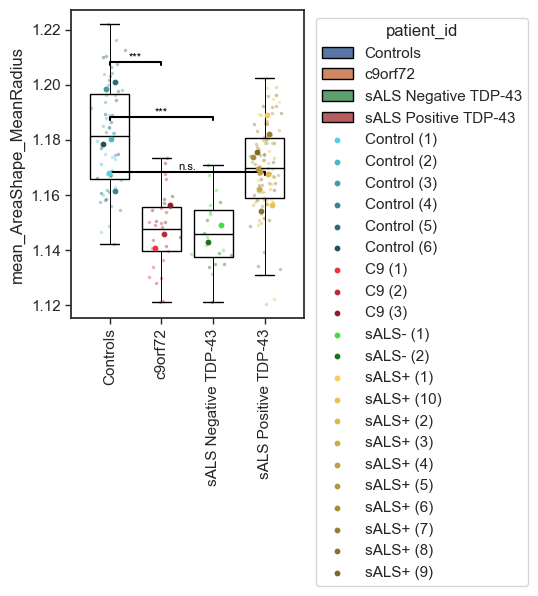

/tmp/ipykernel_1384844/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


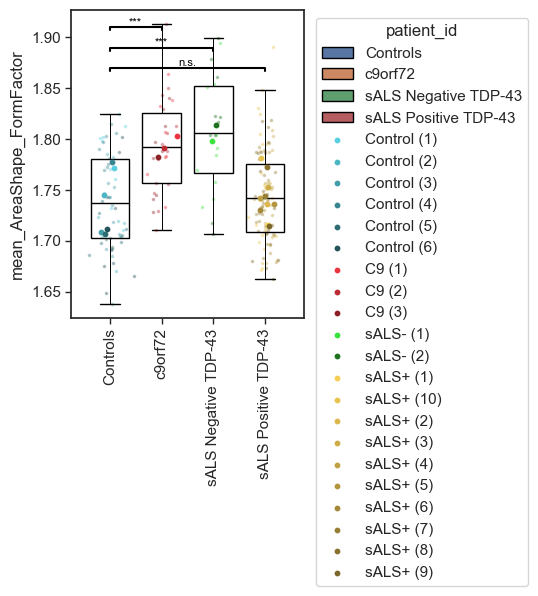

In [18]:
with PdfPages(f"{save_path}/cell_profiler_Coyne_old_p_bodies_DCP1A_test.pdf") as pdf:
    # for cp_feature_col in ["mean_AreaShape_MeanRadius", "mean_AreaShape_Eccentricity"]:
    for cp_feature_col in ["mean_AreaShape_MeanRadius", "mean_AreaShape_FormFactor"]:
        if cp_feature_col in cp_measurements.columns:
            plot_cp_feature_grouped_by_gene(cp_measurements, 
                                              cp_feature_col=cp_feature_col,
                                              group_col='gene_group', 
                                              patient_col="patient_id",
                                              color_mapping=PlotConfig().COLOR_MAPPINGS_ALYSSA, 
                                              model_results_df=results_df_old_coyne,
                                              pdf_file=pdf
                                           )   

        

# New Coyne dataset

In [8]:
ANALYSIS_TYPE = 'PB_profiling/coyne_new_DCP1A'
BATCHES = ['batch1']

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/AlyssaCoyne_new/cell_profiler/PB_profiling/coyne_new_DCP1A'


In [9]:
# Test CP outputs (number of images)
if False:
    pattern = os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, '*', '*', '*', '*', '*', '*')
    # store marker folders by cell line
    for marker_path in glob.glob(pattern):
        if os.path.isdir(marker_path):
            try:
                image_df = pd.read_csv(marker_path +'/Image.csv')
                print(marker_path, image_df.shape)
                #print(image_df[['Count_Pbodies', 'Count_nucleus']].head(10))

                #parts_df = image_df['URL_DAPI'].apply(extract_path_parts)
                #print(marker_path, parts_df['rep'].unique(), parts_df['cell_line'].unique())

                marker = os.path.basename(marker_path)    
                cell_line = Path(marker_path).resolve().parents[3].name
            except FileNotFoundError as e:
                print("!!!!")
                print(e)
        else:
            print(f"Not a marker folder directory:{marker_path}")


## Collect CP files by "cell_line" (paths_by_cell_line[cell_line])

In [10]:
# Collect paths of CP output files
paths_by_cell_line = collect_cp_results_by_cell_line(ANALYSIS_TYPE)

In [11]:
# Load CP data
cp_data = load_cp_results(paths_by_cell_line, REQUIRED_FILES)


number of subjects from cell line C9-CS7VCZ: 2
number of subjects from cell line C9-CS8RFT: 2
number of subjects from cell line Ctrl-EDi029: 2
number of subjects from cell line SALSPositive-CS2FN3: 2
number of subjects from cell line SALSNegative-CS0ANK: 2
number of subjects from cell line Ctrl-EDi022: 2
number of subjects from cell line SALSNegative-CS6ZU8: 2
number of subjects from cell line SALSPositive-CS7TN6: 2
number of subjects from cell line SALSNegative-CS0JPP: 2
number of subjects from cell line Ctrl-EDi037: 2
number of subjects from cell line SALSPositive-CS4ZCD: 2
number of subjects from cell line C9-CS2YNL: 2


In [12]:
# Get the calculated features from all CP output files
cp_measurements = collect_all_features(cp_data, group_by_columns)


C9-CS7VCZ (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
C9-CS8RFT (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
Ctrl-EDi029 (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
SALSPositive-CS2FN3 (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
SALSNegative-CS0ANK (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
Ctrl-EDi022 (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
SALSNegative-CS6ZU8 (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
SALSPositive-CS7TN6 (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
SALSNegative-CS0JPP (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
Ctrl-EDi037 (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
SALSPositive-CS4ZCD (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
C9-CS2YNL (10, 5) (10, 31) (10, 17)
(10, 32)
(10, 45)
Shape after merging is: (120, 45)


In [13]:
# Add patient_id
cp_measurements['patient_id'] = cp_measurements['cell_line']

# Add plate
cp_measurements['plate'] = cp_measurements['cell_line'].apply(assign_plate_Coyne_new)

# Add gene_group
cp_measurements['gene_group'] = cp_measurements['cell_line'].apply(assign_gene_group_Coyne_new)

# Fiilter by lines
lines_to_include = ["Ctrl", "C9", "SALSNegative", "SALSPositive"]
cp_measurements = cp_measurements[cp_measurements['gene_group'].isin(lines_to_include)]
print(cp_measurements.shape)

# Important to put the reference group first in order for mixedlm() - has to be Categorical!
cp_measurements["gene_group"] = pd.Categorical(
    cp_measurements["gene_group"],
    categories=lines_to_include,
    ordered=True
)


(120, 48)


In [14]:
cp_measurements[['rep', 'patient_id']].value_counts()

rep   patient_id         
rep1  C9-CS2YNL              5
      C9-CS7VCZ              5
      C9-CS8RFT              5
      Ctrl-EDi022            5
      Ctrl-EDi029            5
      Ctrl-EDi037            5
      SALSNegative-CS0ANK    5
      SALSNegative-CS0JPP    5
      SALSNegative-CS6ZU8    5
      SALSPositive-CS2FN3    5
      SALSPositive-CS4ZCD    5
      SALSPositive-CS7TN6    5
rep2  C9-CS2YNL              5
      C9-CS7VCZ              5
      C9-CS8RFT              5
      Ctrl-EDi022            5
      Ctrl-EDi029            5
      Ctrl-EDi037            5
      SALSNegative-CS0ANK    5
      SALSNegative-CS0JPP    5
      SALSNegative-CS6ZU8    5
      SALSPositive-CS2FN3    5
      SALSPositive-CS4ZCD    5
      SALSPositive-CS7TN6    5
Name: count, dtype: int64

In [15]:
cp_measurements[['gene_group', 'patient_id']].value_counts()


gene_group    patient_id         
Ctrl          Ctrl-EDi022            10
              Ctrl-EDi029            10
              Ctrl-EDi037            10
C9            C9-CS2YNL              10
              C9-CS7VCZ              10
              C9-CS8RFT              10
SALSNegative  SALSNegative-CS0ANK    10
              SALSNegative-CS0JPP    10
              SALSNegative-CS6ZU8    10
SALSPositive  SALSPositive-CS2FN3    10
              SALSPositive-CS4ZCD    10
              SALSPositive-CS7TN6    10
Name: count, dtype: int64

In [16]:
cp_measurements[['gene_group', 'mean_AreaShape_MeanRadius']].groupby('gene_group', observed=False).describe()

w = cp_measurements.groupby("patient_id")["mean_AreaShape_MeanRadius"].var()
b = cp_measurements.groupby("patient_id")["mean_AreaShape_MeanRadius"].mean().var()
print("median within-patient var:", w.median(), " between-patient var:", b)


median within-patient var: 0.00022828915446708965  between-patient var: 0.00026752422807139927


In [17]:

# Nancy Oct 1 - workaround for mean_AreaShape_MeanRadius
# Fixed effects with patient-clustered SEs (robust & simple)
# when fitting mixed-effect, the true intra-patient variance is tiny relative to residual noise → the optimizer pushes the random effect variance to the boundary (0).
# we treat this as evidence that a random intercept isn’t needed and fall back to a fixed-effects model, but with patient-clustered SEs
# This answers your question (group differences) and still accounts for within-patient dependence, without needing a random-effects variance estimate.
# Clustered SEs = adjust standard errors to account for correlation of images within the same patient.
# Patients don’t appear as explicit terms, so no collinearity with gene_group.



In [19]:
# CellProfiler features
#cp_features_columns = [col for col in cp_measurements.columns if col not in group_by_columns + ['patient_id', 'plate', 'gene_group']]

cp_features_columns = ["mean_AreaShape_MeanRadius"]#, "mean_AreaShape_Eccentricity"]
                            

results_df_new_coyne = run_analysis_generate_report(
                                    df=cp_measurements,
                                    feature_columns=cp_features_columns,
                                    group_col="gene_group",
                                    batch_col="patient_id",
                                    output_dir=os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, 'mixed_effect_report'),
                                    cov_type="cluster"
                                )

results_df_new_coyne




Analysing CP feature: mean_AreaShape_MeanRadius
⚠️ Fallback to fixed-effects model for feature: mean_AreaShape_MeanRadius with cov_type=cluster
                            OLS Regression Results                            
Dep. Variable:          feature_value   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     7.842
Date:                Mon, 06 Oct 2025   Prob (F-statistic):            0.00447
Time:                        22:54:41   Log-Likelihood:                 274.62
No. Observations:                 120   AIC:                            -541.2
Df Residuals:                     116   BIC:                            -530.1
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                    coef    std err          z 

/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/code/cp_effect_size_utils.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _, results_df_wo_intercept["fdr_pval_global"], _, _ = multipletests(results_df_wo_intercept["pval"], method="fdr_bh")


,feature,comparison,effect_size,pval,ci_lower,ci_upper,group_var,residual_var,significance,fit_status,used_fixed_model,aic,bic,loglik,r_squared,fdr_pval_global
0,mean_AreaShape_MeanRadius,Intercept,1.191646,0.000000,1.186832,1.196461,NaN,0.000623,****,fallback_ols_fixed_batch_cov_type+cluster,True,-541.234141,-530.084174,274.61707,0.134446,NaN
1,mean_AreaShape_MeanRadius,C9,-0.015703,0.000003,-0.022307,-0.009099,NaN,0.000623,****,fallback_ols_fixed_batch_cov_type+cluster,True,-541.234141,-530.084174,274.61707,0.134446,0.000009
2,mean_AreaShape_MeanRadius,SALSNegative,0.009530,0.500094,-0.018169,0.037229,NaN,0.000623,ns,fallback_ols_fixed_batch_cov_type+cluster,True,-541.234141,-530.084174,274.61707,0.134446,0.500094
3,mean_AreaShape_MeanRadius,SALSPositive,-0.010181,0.051467,-0.020427,0.000065,NaN,0.000623,ns,fallback_ols_fixed_batch_cov_type+cluster,True,-541.234141,-530.084174,274.61707,0.134446,0.077200


/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


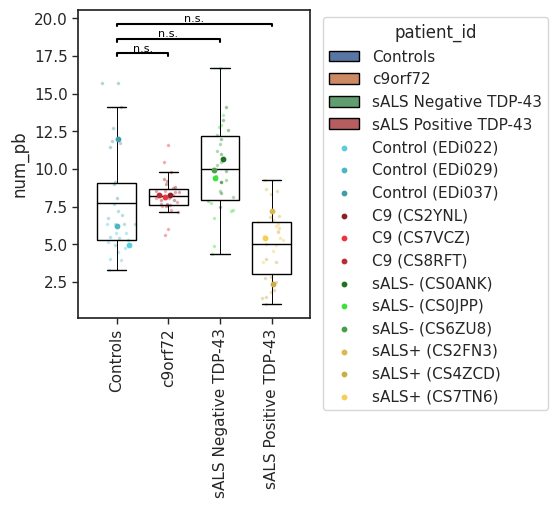

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


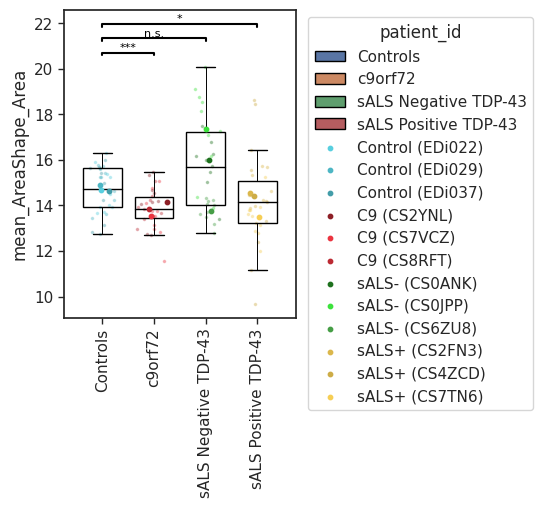

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


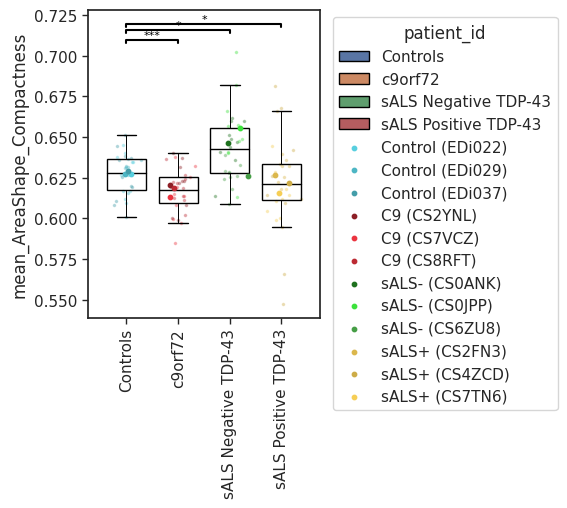

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


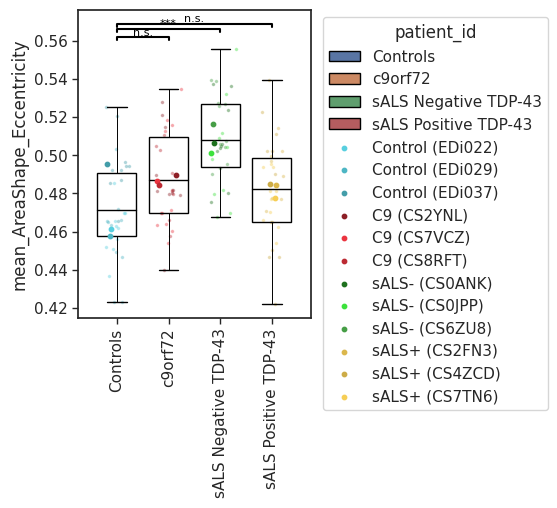

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


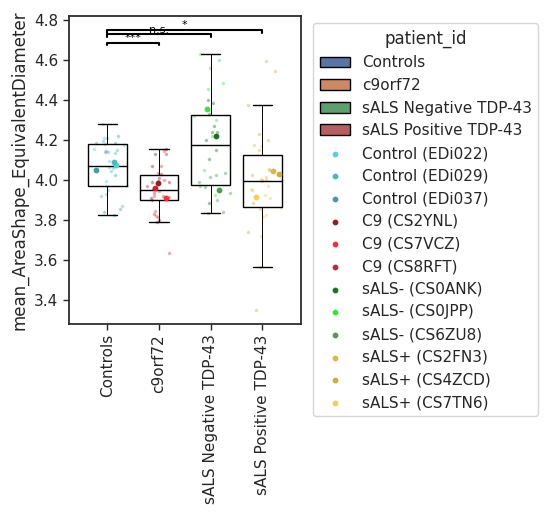

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


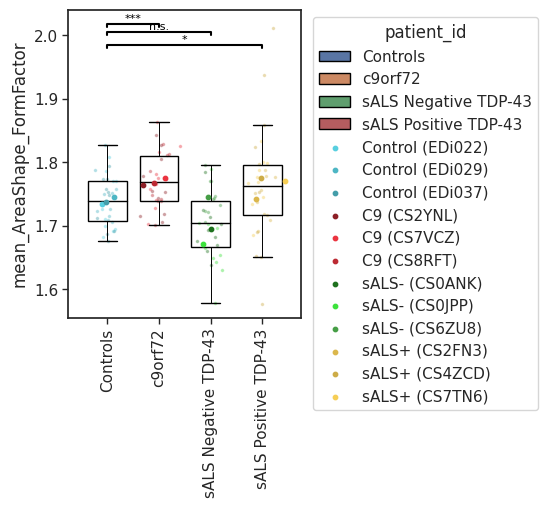

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


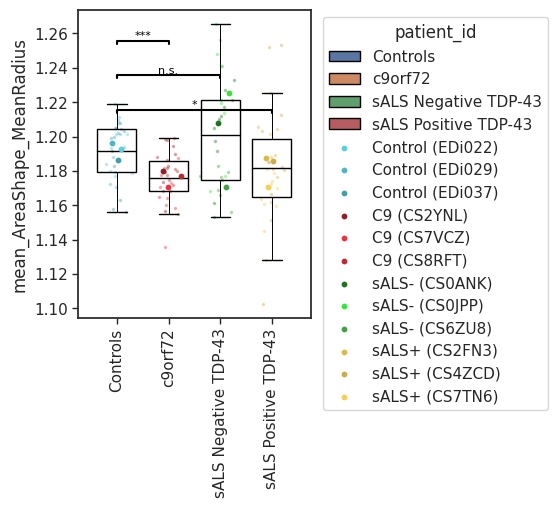

/tmp/ipykernel_1266061/1773598419.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


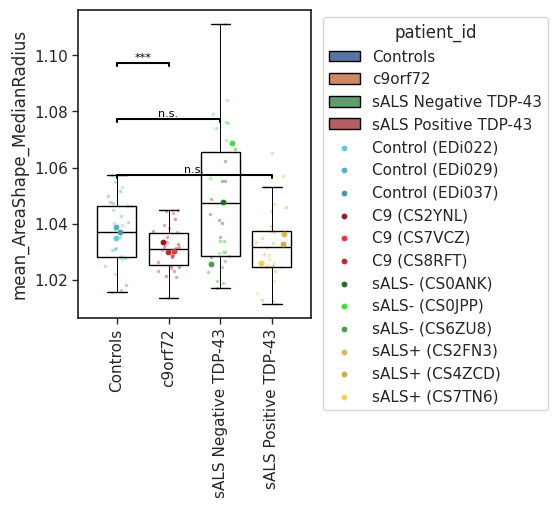

In [ ]:
with PdfPages(f"{save_path}/cell_profiler_Coyne_new_p_bodies_DCP1A_test.pdf") as pdf:
    for cp_feature_col in ["mean_AreaShape_MeanRadius", "mean_AreaShape_Eccentricity"]:
        if cp_feature_col in cp_measurements.columns:
            plot_cp_feature_grouped_by_gene(cp_measurements, 
                                              cp_feature_col=cp_feature_col,
                                              group_col='gene_group', 
                                              patient_col="patient_id",
                                              color_mapping=PlotConfig().COLOR_MAPPINGS_ALYSSA, 
                                              model_results_df=results_df_new_coyne,
                                              pdf_file=pdf
                                           )   

        

In [28]:
# NANCY TBD!!!!


# Additional Recommendations
# Check residuals: Ensure assumptions of normality and homoscedasticity are not violated.

# Multiple testing correction: If testing multiple features (e.g., 20 CellProfiler features), apply FDR correction (Benjamini-Hochberg).

# Visualize: Use boxplots or violin plots grouped by gene_group, faceted by patient if needed, to interpret effects.

# Optional Enhancements
# Multiple feature testing: Apply FDR correction using statsmodels.stats.multitest.multipletests

# Model diagnostics: Plot residuals (result.resid) to verify model assumptions

# Batch effect: Add batch as an additional fixed effect if needed: model = smf.mixedlm("measurement ~ gene_group + batch", data, groups=data["patient"])


In [29]:
print("Done!")

Done!
